# This code represents a trading strategy for 1 hour trading intervals
# The predictor is the high price of the ADA cryptocurrency and the minimum threshold is 0.5

In [1]:
################# IMPORTS AND SETUP ##############################


from binance import Client
import pandas as pd
from supporting_functionsM2 import *
from API_KEYS2 import get_keys

# Setting up binance client
KEY, SECRET = get_keys()
client = Client(KEY, SECRET)

# Defining setup variables for creating dataset
# start = "1513724400" # 20.12.2017
start = "1483225200" # 01.01.2017
periods = 101 # approx 8 years
TICKER = "ADAUSDT"
options = ["high", "low", "close", "volume"] # BASE OPTIONS
EPOCHS=5
THRESHOLD=0.5 # Threshold value for lableling, ie. BTCUSDT:close = 0.5 > 0.0 => label = 1, if BTCUSDT:close = -0.5 < 0.0 => 0
PREDICTOR=f"{TICKER}:high"
TIME = f"{TICKER}:time"

In [2]:
################# DOWNLOADING RAW DATA ##########################################

periods = periods
LIMIT = 720 # 720h = 30 days
start1 = start
end1 = next_30_days_unix_timestamp(start1)

############################################ DOWNLOADING DATA ###################################################################### 
data = pd.DataFrame(columns=["time", "open", "high", "low", "close", "volume"])

# downloading the first set of candlestick lines
klines = client.get_historical_klines(TICKER, client.KLINE_INTERVAL_1HOUR, limit=LIMIT, start_str=unix_to_datetime_string(start1, in_milliseconds=False), end_str=unix_to_datetime_string(end1, in_milliseconds=False))
    # print(klines)

# Converting data from list to pandas dataframe
new_data = pd.DataFrame(data=[row[0:6] for row in klines], columns=["time", "open", "high", "low", "close", "volume"])
data = pd.concat([data, new_data], ignore_index=True)

for i in range(periods - 1):
    # Moving the start and end interval to next day
    start1 = next_30_days_unix_timestamp(start1)
    end1 = next_30_days_unix_timestamp(start1) 

    # downloading candlestick lines
    klines = client.get_historical_klines(TICKER, client.KLINE_INTERVAL_1HOUR, limit=LIMIT, start_str=unix_to_datetime_string(start1, in_milliseconds=False), end_str=unix_to_datetime_string(end1, in_milliseconds=False))
    # print(klines)

    # Converting data from list to pandas dataframe
    new_data = pd.DataFrame(data=[row[0:6] for row in klines], columns=["time", "open", "high", "low", "close", "volume"])

    # concatinating the new data with the existing data
    data = pd.concat([data, new_data], ignore_index=True)

# converting all time values from unix to readable string, not important, just for visual purposes and fact checking
data["time"] = data["time"].apply(unix_to_datetime_string) #converting time from 

raw_data = data
display(raw_data)


,time,open,high,low,close,volume
0,2018-04-17 04:00:00,0.25551000,0.28800000,0.25551000,0.26664000,8143693.23000000
1,2018-04-17 05:00:00,0.26660000,0.27798000,0.26010000,0.26200000,8317923.61000000
2,2018-04-17 06:00:00,0.26221000,0.26396000,0.24800000,0.25664000,8420095.41000000
3,2018-04-17 07:00:00,0.25662000,0.26300000,0.25489000,0.25698000,4686043.91000000
4,2018-04-17 08:00:00,0.25636000,0.25998000,0.25229000,0.25631000,3510038.13000000
...,...,...,...,...,...,...
61338,2025-04-18 18:00:00,0.62620000,0.62920000,0.62480000,0.62700000,3811821.50000000
61339,2025-04-18 19:00:00,0.62690000,0.62850000,0.62530000,0.62740000,1910694.50000000
61340,2025-04-18 20:00:00,0.62730000,0.62870000,0.62560000,0.62810000,2539948.40000000
61341,2025-04-18 21:00:00,0.62810000,0.63180000,0.62620000,0.63100000,6388871.80000000


In [3]:
raw_close = raw_data['close'].to_list()
print(f"PERCENT RETURN EVALUATION SET: {round(percent_difference(float(raw_close[-10000]), float(raw_close[-1])), 3)}%")

PERCENT RETURN EVALUATION SET: 1.966%


In [4]:
########################################## PREPROCESSING DATA ####################################################################

# New dataobject for storing processed data
# processed_data = {f"{TICKER}:time": [], f"{TICKER}:open": [], f"{TICKER}:high": [], f"{TICKER}:low": [], f"{TICKER}:close": [], f"{TICKER}:volume": []}
processed_data = {f"{TICKER}:time": [], f"{TICKER}:high": [], f"{TICKER}:low": [], f"{TICKER}:close": [], f"{TICKER}:volume": []}

for i, o in enumerate(raw_data["open"]): #o == open, the open price value of the candle stick
    if i == 0: #Skipping the first hour to calculate the percent diff using this hour
        continue

    if o == 0:
        continue

    processed_data[f"{TICKER}:time"].append(raw_data["time"][i]) #time is the same
    # processed_data[f"{TICKER}:open"].append(percent_difference(float(data["open"][i-1]), float(o))) # percent difference between the opening price of the prior candlestick vs. open of current candle
    processed_data[f"{TICKER}:high"].append(percent_difference(float(o), float(raw_data["high"][i]))) # percent diff between open and high
    processed_data[f"{TICKER}:low"].append(percent_difference(float(o), float(raw_data["low"][i]))) # percent diff between open and low
    processed_data[f"{TICKER}:close"].append(percent_difference(float(o), float(raw_data["close"][i]))) # percent diff between open and close
    processed_data[f"{TICKER}:volume"].append(percent_difference(float(raw_data["volume"][i-1]), float(raw_data["volume"][i]))) # percent difference between the colume of the prior candlestick vs. open of current candle


# processed_data = pd.DataFrame(data=processed_data, columns=[f"{TICKER}:time", f"{TICKER}:open", f"{TICKER}:high", f"{TICKER}:low", f"{TICKER}:close", f"{TICKER}:volume"])
processed_data = pd.DataFrame(data=processed_data, columns=[f"{TICKER}:time", f"{TICKER}:high", f"{TICKER}:low", f"{TICKER}:close", f"{TICKER}:volume"])
display(processed_data)

,ADAUSDT:time,ADAUSDT:high,ADAUSDT:low,ADAUSDT:close,ADAUSDT:volume
0,2018-04-17 05:00:00,4.268567,-2.438110,-1.725431,2.139452
1,2018-04-17 06:00:00,0.667404,-5.419320,-2.124252,1.228333
2,2018-04-17 07:00:00,2.486166,-0.674149,0.140285,-44.346902
3,2018-04-17 08:00:00,1.412077,-1.587611,-0.019504,-25.095919
4,2018-04-17 09:00:00,1.361632,-1.291405,-0.370645,-23.658621
...,...,...,...,...,...
61337,2025-04-18 18:00:00,0.479080,-0.223571,0.127755,12.376273
61338,2025-04-18 19:00:00,0.255224,-0.255224,0.079758,-49.874502
61339,2025-04-18 20:00:00,0.223179,-0.271003,0.127531,32.933255
61340,2025-04-18 21:00:00,0.589078,-0.302500,0.461710,151.535496


In [5]:
############################# STATISTICAL ANALYSIS OF PROCESSED DATA #######################################
import statistics as st

high_data_processed = processed_data[f"{TICKER}:high"].to_list()
high_data_processed = high_data_processed[:-10000]
print(f"TOTAL DATAPOINTS: {len(high_data_processed)}")
print(f"MEAN HIGH: {st.mean(high_data_processed)}")
print(f"MEDIAN HIGH: {st.median(high_data_processed)}")

print(f"MAX HIGH IN DATASET: {max(high_data_processed)}")
print(f"OCCURRENCES OVER 0.5: {sum(x > 0.5 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.5 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.6: {sum(x > 0.6 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.6 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.7: {sum(x > 0.7 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.7 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.8: {sum(x > 0.8 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.8 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.9: {sum(x > 0.9 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.9 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 1: {sum(x > 1 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 1 for x in high_data_processed) / len(high_data_processed), 2)}%")
print("----------------------------------------------------------------------")

print("EVALUATION DATASET STATISTICS")
high_data_processed = processed_data[f"{TICKER}:high"].to_list()
high_data_processed = high_data_processed[-10000:]
print(f"TOTAL DATAPOINTS: {len(high_data_processed)}")
print(f"MEAN HIGH: {st.mean(high_data_processed)}")
print(f"MEDIAN HIGH: {st.median(high_data_processed)}")

print(f"MAX HIGH IN DATASET: {max(high_data_processed)}")
print(f"OCCURRENCES OVER 0.5: {sum(x > 0.5 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.5 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.6: {sum(x > 0.6 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.6 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.7: {sum(x > 0.7 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.7 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.8: {sum(x > 0.8 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.8 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.9: {sum(x > 0.9 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.9 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 1: {sum(x > 1 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 1 for x in high_data_processed) / len(high_data_processed), 2)}%")
print("----------------------------------------------------------------------")

TOTAL DATAPOINTS: 51342
MEAN HIGH: 0.7524778814373801
MEDIAN HIGH: 0.4828253621253047
MAX HIGH IN DATASET: 27.907906307458646
OCCURRENCES OVER 0.5: 24961 - PERCENT OF DATASET: 0.49%
OCCURRENCES OVER 0.6: 21581 - PERCENT OF DATASET: 0.42%
OCCURRENCES OVER 0.7: 18614 - PERCENT OF DATASET: 0.36%
OCCURRENCES OVER 0.8: 16055 - PERCENT OF DATASET: 0.31%
OCCURRENCES OVER 0.9: 13866 - PERCENT OF DATASET: 0.27%
OCCURRENCES OVER 1: 12085 - PERCENT OF DATASET: 0.24%
----------------------------------------------------------------------
EVALUATION DATASET STATISTICS
TOTAL DATAPOINTS: 10000
MEAN HIGH: 0.7296755414520119
MEDIAN HIGH: 0.4709807203604268
MAX HIGH IN DATASET: 38.882025941939474
OCCURRENCES OVER 0.5: 4792 - PERCENT OF DATASET: 0.48%
OCCURRENCES OVER 0.6: 4095 - PERCENT OF DATASET: 0.41%
OCCURRENCES OVER 0.7: 3512 - PERCENT OF DATASET: 0.35%
OCCURRENCES OVER 0.8: 2994 - PERCENT OF DATASET: 0.3%
OCCURRENCES OVER 0.9: 2572 - PERCENT OF DATASET: 0.26%
OCCURRENCES OVER 1: 2206 - PERCENT OF D

In [6]:
########################### LABELING THE DATA ##################################


# column_labels = ["BTCUSDT:time"] # name of the columns for the return dataframe
column_labels = ["time"] # name of the columns for the return dataframe

# filling up the list with labels for the columns
for roundd in range(EPOCHS):
    for option in options:
        column_labels.append(f"{TICKER}:{option}{roundd}")

column_labels.append("Label")


# filling up list of data, row by row in the dataset
labelled_data_rows = [] # this list stores all the rows filled with all the data
for i in range(len(processed_data[TIME]) - EPOCHS): #looping from the third element to the third last element, with stepsize 1, if epoch=3
    data_row = []

    data_row.append(processed_data[TIME][i + EPOCHS - 1])

    for t in range(EPOCHS):
        for option in options:
            data_row.append(processed_data[f"{TICKER}:{option}"][i + t])

    if processed_data[PREDICTOR][i + EPOCHS] > THRESHOLD: # here we use the threshold
        data_row.append(1)
    else:
        data_row.append(0)

    labelled_data_rows.append(data_row)


labelled_data_frame = pd.DataFrame(labelled_data_rows, columns=column_labels)
display(labelled_data_frame)

,time,ADAUSDT:high0,ADAUSDT:low0,ADAUSDT:close0,ADAUSDT:volume0,ADAUSDT:high1,ADAUSDT:low1,ADAUSDT:close1,ADAUSDT:volume1,ADAUSDT:high2,...,ADAUSDT:volume2,ADAUSDT:high3,ADAUSDT:low3,ADAUSDT:close3,ADAUSDT:volume3,ADAUSDT:high4,ADAUSDT:low4,ADAUSDT:close4,ADAUSDT:volume4,Label
0,2018-04-17 09:00:00,4.268567,-2.438110,-1.725431,2.139452,0.667404,-5.419320,-2.124252,1.228333,2.486166,...,-44.346902,1.412077,-1.587611,-0.019504,-25.095919,1.361632,-1.291405,-0.370645,-23.658621,0
1,2018-04-17 10:00:00,0.667404,-5.419320,-2.124252,1.228333,2.486166,-0.674149,0.140285,-44.346902,1.412077,...,-25.095919,1.361632,-1.291405,-0.370645,-23.658621,0.288780,-1.190244,0.050732,-20.581889,1
2,2018-04-17 11:00:00,2.486166,-0.674149,0.140285,-44.346902,1.412077,-1.587611,-0.019504,-25.095919,1.361632,...,-23.658621,0.288780,-1.190244,0.050732,-20.581889,2.192059,-0.538264,1.915126,-6.651501,1
3,2018-04-17 12:00:00,1.412077,-1.587611,-0.019504,-25.095919,1.361632,-1.291405,-0.370645,-23.658621,0.288780,...,-20.581889,2.192059,-0.538264,1.915126,-6.651501,2.157336,-1.919761,-1.218531,95.086660,1
4,2018-04-17 13:00:00,1.361632,-1.291405,-0.370645,-23.658621,0.288780,-1.190244,0.050732,-20.581889,2.192059,...,-6.651501,2.157336,-1.919761,-1.218531,95.086660,0.849529,-0.306451,-0.108616,-51.258434,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61332,2025-04-18 17:00:00,0.226868,-0.340301,0.145843,-26.006756,0.420780,-0.388412,-0.097103,79.098599,0.113397,...,47.491798,0.600454,-0.097371,0.600454,-20.884357,1.080819,-0.032263,1.000161,37.673761,0
61333,2025-04-18 18:00:00,0.420780,-0.388412,-0.097103,79.098599,0.113397,-0.631784,-0.178195,47.491798,0.600454,...,-20.884357,1.080819,-0.032263,1.000161,37.673761,0.479080,-0.223571,0.127755,12.376273,0
61334,2025-04-18 19:00:00,0.113397,-0.631784,-0.178195,47.491798,0.600454,-0.097371,0.600454,-20.884357,1.080819,...,37.673761,0.479080,-0.223571,0.127755,12.376273,0.255224,-0.255224,0.079758,-49.874502,0
61335,2025-04-18 20:00:00,0.600454,-0.097371,0.600454,-20.884357,1.080819,-0.032263,1.000161,37.673761,0.479080,...,12.376273,0.255224,-0.255224,0.079758,-49.874502,0.223179,-0.271003,0.127531,32.933255,1


# Model Training

This code block divides the dataset into a training dataset and trains a new model using the **AutoGluon Tabular** predictor.

In [7]:
################################ TRAINING NEW MODEL #######################################
from autogluon.tabular import TabularDataset, TabularPredictor

# defining training size and colums to use for training within the labelled dataset
VALIDATION_SIZE = 10000
columns_to_use = [f"{TICKER}:high0", f"{TICKER}:low0", f"{TICKER}:close0", f"{TICKER}:volume0", f"{TICKER}:high1", f"{TICKER}:low1", f"{TICKER}:close1", f"{TICKER}:volume1", f"{TICKER}:high2", f"{TICKER}:low2", f"{TICKER}:close2", f"{TICKER}:volume2", f"{TICKER}:high3", f"{TICKER}:low3", f"{TICKER}:close3", f"{TICKER}:volume3", f"{TICKER}:high4", f"{TICKER}:low4", f"{TICKER}:close4", f"{TICKER}:volume4", "Label"]
LABEL = "Label"

# defining training data
training_dataframe = labelled_data_frame.iloc[:-VALIDATION_SIZE].copy()
train_data_frame2 = training_dataframe[columns_to_use]
train_tabular_dataset = TabularDataset(train_data_frame2)

# # Training model -> TabularPredictor
# predictor = TabularPredictor(label=label, eval_metric="balanced_accuracy", positive_class=1).fit(train_tabular_dataset, num_bag_folds=5, num_bag_sets=5, num_stack_levels=3)
# predictor = TabularPredictor(label=label, eval_metric="accuracy").fit(train_tabular_dataset, presets="high_quality")
predictor = TabularPredictor(label=LABEL).fit(train_tabular_dataset)



c:\Users\47981\Desktop\MasterThesis\Repo\MasterThesis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No path specified. Models will be saved in: "AutogluonModels\ag-20250603_094006"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       4.11 GB / 15.92 GB (25.8%)
Disk Space Avail:   134.91 GB / 475.69 GB (28.4%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Defau

# Model Evaluation

This code block divides the dataset into a validation dataset and evaluates the model using the **AutoGluons** inbuilt evaluation library. In addition the model is backtested using the validation set to measure its performance and calulate its "expected return" over the period.

In [8]:
#################### MODEL EVALUATION ################################

# Defining the testing set using the training size and columns to use
testing_dataframe = labelled_data_frame.tail(VALIDATION_SIZE).copy()
#display(testing_dataframe)
test_data_frame2 = testing_dataframe[columns_to_use]
test_tabular_dataset = TabularDataset(test_data_frame2)

######## Making predictions
y_pred = predictor.predict(test_tabular_dataset.drop(columns=[LABEL]))
display(y_pred)


#### Evaluation
eval_report = predictor.evaluate(test_tabular_dataset, detailed_report=True)
display(eval_report)

feature_importance = predictor.feature_importance(test_tabular_dataset)
display(feature_importance)


51337    0
51338    0
51339    0
51340    0
51341    0
        ..
61332    0
61333    0
61334    0
61335    0
61336    0
Name: Label, Length: 10000, dtype: int64

{'accuracy': 0.6457,
 'balanced_accuracy': 0.642506295695078,
 'mcc': 0.2887428494106579,
 'roc_auc': 0.6950578593290405,
 'f1': 0.6047964305633017,
 'precision': 0.6496525281572011,
 'recall': 0.5657345575959933,
 'confusion_matrix':       0     1
 0  3746  1462
 1  2081  2711,
 'classification_report': {'0': {'precision': 0.6428694010640124,
   'recall': 0.7192780337941628,
   'f1-score': 0.6789306751246036,
   'support': 5208.0},
  '1': {'precision': 0.6496525281572011,
   'recall': 0.5657345575959933,
   'f1-score': 0.6047964305633017,
   'support': 4792.0},
  'accuracy': 0.6457,
  'macro avg': {'precision': 0.6462609646106068,
   'recall': 0.642506295695078,
   'f1-score': 0.6418635528439527,
   'support': 10000.0},
  'weighted avg': {'precision': 0.6461198755670684,
   'recall': 0.6457,
   'f1-score': 0.6434055451308277,
   'support': 10000.0}}}

Computing feature importance via permutation shuffling for 20 features using 5000 rows with 5 shuffle sets...
	1.45s	= Expected runtime (0.29s per shuffle set)
	0.59s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
ADAUSDT:low4,0.04904,0.006276,0.000031,5,0.061962,0.036118
ADAUSDT:high4,0.03764,0.003692,0.000011,5,0.045241,0.030039
ADAUSDT:close4,0.00628,0.001137,0.000123,5,0.008620,0.003940
ADAUSDT:low3,0.00532,0.003880,0.018716,5,0.013308,-0.002668
ADAUSDT:high3,0.00504,0.004358,0.030461,5,0.014012,-0.003932
ADAUSDT:high1,0.00376,0.002812,0.020173,5,0.009550,-0.002030
ADAUSDT:low2,0.00252,0.003152,0.074148,5,0.009009,-0.003969
ADAUSDT:low0,0.00112,0.002292,0.167942,5,0.005839,-0.003599
ADAUSDT:high2,0.00060,0.001122,0.149007,5,0.002911,-0.001711
ADAUSDT:volume1,0.00020,0.000721,0.284364,5,0.001685,-0.001285


In [ ]:
import re
import pandas as pd

METRIC_RE = re.compile(r":([a-zA-Z]+?)(\d+)$")   # capture metric & hour suffix


def analyze_feature_importance(feature_names, importances):
    """
    Print a short report on a model’s feature-importance vector.

    Parameters
    ----------
    feature_names : list[str]
        All feature names, e.g. ["SOLUSDT:high4", "SOLUSDT:low2", ...]
    importances : list[float]
        Matching importance values, same length/order as `feature_names`
    """
    if len(feature_names) != len(importances):
        raise ValueError("feature_names and importances must be the same length!")

    # ── Build a DataFrame ────────────────────────────────────────────────────
    df = pd.DataFrame(
        {"feature": feature_names, "importance": importances}
    ).assign(
        metric=lambda d: d["feature"].str.extract(METRIC_RE)[0].str.lower(),
        hour=lambda d: pd.to_numeric(
            d["feature"].str.extract(METRIC_RE)[1], errors="coerce"
        ),
    )

    # Drop rows we could not parse
    df = df.dropna(subset=["metric", "hour"]).copy()
    df["hour"] = df["hour"].astype(int)

    # ── 1. % of positive importances ────────────────────────────────────────
    pct_pos = (df["importance"] > 0).mean() * 100

    # ── 2. Rank by hour (sum of importances per lag) ────────────────────────
    hour_scores = df.groupby("hour")["importance"].sum().sort_values(ascending=False)
    hour_ranking = hour_scores.index.tolist()

    # ── 3. Rank by metric (sum of importances per metric) ───────────────────
    metric_scores = (
        df.groupby("metric")["importance"].sum().sort_values(ascending=False)
    )
    metric_ranking = metric_scores.index.tolist()

    # ── Report ──────────────────────────────────────────────────────────────
    print(f"{pct_pos:.1f}% of the {len(df)} features have **positive** importance.\n")

    print("Ranking by HOUR (most → least important):")
    for i, h in enumerate(hour_ranking, 1):
        print(f"  {i}. h{h:<1}   sum importance = {hour_scores[h]:.6f}")

    print("\nRanking by METRIC (most → least important):")
    for i, m in enumerate(metric_ranking, 1):
        print(f"  {i}. {m:<6} sum importance = {metric_scores[m]:.6f}")

    top_features = (
        df.loc[df["importance"].abs().sort_values(ascending=False).index]
        .head(5)[["feature", "importance"]]
    )
    print("\nTop 5 individual features:")
    for feat, imp in top_features.itertuples(index=False):
        print(f"  {feat:<25} {imp:.6f}")




analyze_feature_importance(feature_importance.index.to_list(), feature_importance['importance'].to_list())

In [9]:
# ANALYSIS OF PREDICTIONS AND PROBABILITIES

import statistics as st

# making and processing probabilities from evaluation dataset
y_prob = predictor.predict_proba(test_tabular_dataset.drop(columns=[LABEL]))

validation_probabilities = pd.DataFrame(y_prob).reset_index(drop=True) # probability for each prediction
validation_predictions = pd.DataFrame(y_pred).reset_index(drop=True)
validation_dataset = pd.DataFrame(test_data_frame2).reset_index(drop=True)
#display(validation_probabilities)
#display(validation_predictions)
#display(validation_dataset)

print(f"MEAN PROB 1 CLASSIFICATION: {st.mean(validation_probabilities[1].to_list())}")
print(f"MAX PROB 1 CLASSIFICATION: {max(validation_probabilities[1].to_list())}")
print(f"MIN PROB 1 CLASSIFICATION: {min(validation_probabilities[1].to_list())}")

count_above_07 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.7)
print("COUNT OF NUMBERS > 0.7:", count_above_07)

count_above_08 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.8)
print("COUNT OF NUMBERS > 0.8:", count_above_08)

count_above_09 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.9)
print("COUNT OF NUMBERS > 0.9:", count_above_09)








MEAN PROB 1 CLASSIFICATION: 0.47714461235255
MAX PROB 1 CLASSIFICATION: 0.827313244342804
MIN PROB 1 CLASSIFICATION: 0.17777591943740845
COUNT OF NUMBERS > 0.7: 621
COUNT OF NUMBERS > 0.8: 47
COUNT OF NUMBERS > 0.9: 0


NUMBER OF TRADES: 621
ACCURACY: 79.87%
RETURN: 39.6%
SHARP RATIO: 1.2692060327149066
SHARP RATIO ONLY HOLDING ASSET: 0.5622840724021505
MEAN RETURN BAD TRADES: -1.680056
----------------------------------
-1.323
-0.13
-1.774
0.0
0.041
-2.11
-1.887
-0.566
-1.763
-2.433
-2.197
-1.386
-3.847
-0.458
-0.787
-1.391
-11.744
0.09
-2.632
0.271
-0.105
-2.844
-0.966
0.208
0.074
-0.19
-4.992
-1.849
0.203
-0.215
0.062
-1.335
-0.57
0.276
-6.693
-0.483
-2.642
-1.542
-0.306
-1.773
-0.105
-0.824
-3.289
-1.012
0.212
-1.09
-0.625
-1.391
-5.649
-0.941
-0.5
-0.054
-0.886
-3.441
-1.456
-1.334
-0.739
-1.467
-1.228
-1.164
-0.396
-0.862
-1.116
-0.483
-0.159
-5.967
-2.651
-0.471
-4.409
-1.24
-4.159
-5.622
-2.539
-0.586
-0.491
-0.652
-0.758
-0.785
-0.743
0.211
-0.433
-0.229
-2.455
-1.451
-4.662
-2.196
-3.112
-4.89
-0.778
-1.288
-1.003
-0.755
-3.868
-4.993
-2.95
-0.531
-0.289
-4.362
-2.192
-2.776
-1.953
-1.536
-0.284
-2.224
-1.208
-0.573
-0.548
-1.119
-7.159
-4.41
-0.473
-0.17
-0.876
-2.515
-1.475
-3.56
-2.256
-0

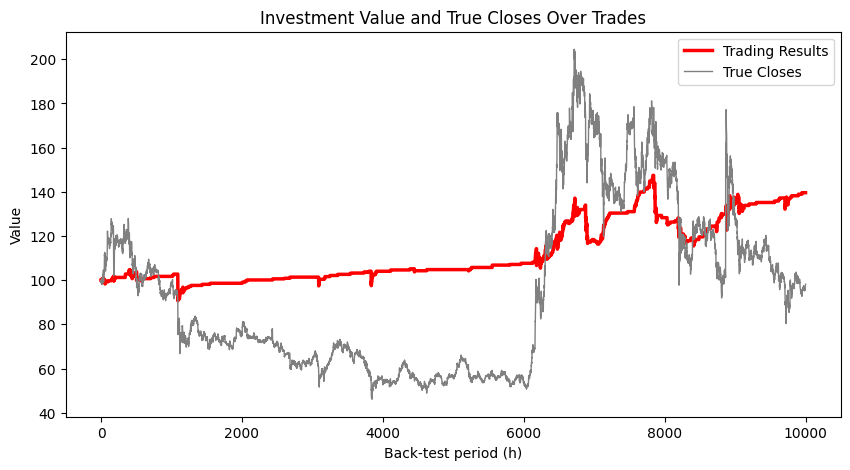

In [10]:
import matplotlib.pyplot as plt

# --- Constants ---
MINIMUM_PROBABILITY = 0.7
LEVERAGE = 1
FEE = 0.0
GAIN = 0.5 - FEE  # Interpreted as a percentage (e.g., 0.5% if multiplied by /100)


# --- Tracking variables ---
correct_trades = 0
total_trades = 0
bad_trades = []
all_trades = []

initial_investment = 100
current_investment = initial_investment
investment_history = []

# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        total_trades += 1
        
        # Check if the prediction was correct
        if validation_predictions["Label"][idx] == validation_dataset["Label"][idx]:
            correct_trades += 1
            
            # Record the "gain" in your trade list
            all_trades.append(GAIN * LEVERAGE)
            
            # Update current_investment by a factor of (1 + gain%)
            current_investment *= 1 + (GAIN / 100 * LEVERAGE)
        
        else:
            # Grab the next close price; watch out for index out-of-range in real code
            true_close = (validation_dataset[f"{TICKER}:close4"][idx + 1]) - FEE
            
            # Record the trade details
            bad_trades.append(round(true_close * LEVERAGE, 3))
            all_trades.append(true_close * LEVERAGE)

            # Update current_investment by (1 + some factor of true_close?)
            current_investment *= 1 + (true_close / 100 * LEVERAGE)
    
    else:
        all_trades.append(0)

    # In all cases, record the current investment amount
    investment_history.append(current_investment)

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0
total_return = current_investment - initial_investment

# --- Print results ---
#print(f"CORRECT: {correct_trades}")
#print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
print(f"ACCURACY: {round(win_rate, 2)}%")
print(f"RETURN: {round(total_return, 2)}%")
#print(f"INVESTMENT VALUE: {round(current_investment, 2)}")
print(f"SHARP RATIO: {calculate_sharpe_ratio(all_trades)}")
sharpe_ratio9999 = calculate_sharpe_ratio(validation_dataset[f"{TICKER}:close4"].to_list())
print(f"SHARP RATIO ONLY HOLDING ASSET: {sharpe_ratio9999}")
print(f"MEAN RETURN BAD TRADES: {st.mean(bad_trades)}")
print("-" * 34)

# Print information about bad trades
for trade in bad_trades:
    print(trade)

# --- Plot the investment history ---
true_closes_list = validation_dataset[f"{TICKER}:close4"].to_list()
true_close_base = 100
true_close_base_list = []

for close in true_closes_list:
    true_close_base *= 1 + (close / 100)
    true_close_base_list.append(true_close_base)


plt.figure(figsize=(10,5))
plt.plot(investment_history, label="Trading Results", color='red', linewidth=2.5)
plt.plot(true_close_base_list, label="True Closes", color='gray', linewidth=1)
plt.xlabel("Back-test period (h)")
plt.ylabel("Value")
plt.title("Investment Value and True Closes Over Trades")
plt.legend()
plt.show()

In [ ]:
############### ANALYSIS OF TRADING USING CLOSING PRICE ################################

# --- Constants ---
MINIMUM_PROBABILITY = 0.8
TRADING_FEE = 0.25

# --- Tracking variables ---
correct_trades = 0
total_trades = 0
wrong_trades = 0

all_trades = []
good_trades = []
bad_trades = []

# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        true_close = validation_dataset[f"{TICKER}:close4"][idx + 1] - TRADING_FEE
        
        if true_close >= 0:
            correct_trades += 1
            good_trades.append(true_close)
        else:
            bad_trades.append(true_close)



        total_trades += 1
        all_trades.append(true_close)
            

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0

# --- Print results ---
print(f"CORRECT: {correct_trades}")
print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
print(f"WIN RATE: {round(win_rate, 2)}%")
print("-" * 34)

print(f"MEAN GOOD TRADES: {st.mean(good_trades)}")
print(f"MEAN BAD TRADES: {st.mean(bad_trades)}")

investtt = 100
investment_history2 = []
for trade in all_trades:
    investtt *= 1 + (trade / 100)
    investment_history2.append(investtt)
    # print(trade)

print(f"RETURN: {round(investtt - 100, 3)} %")

# --- Plot the investment history ---
plt.plot(investment_history2)
plt.xlabel("Trade Index")
plt.ylabel("Investment Value")
plt.title("Investment Value Over Trades")
plt.show()

In [ ]:
############### ANALYSIS OF TRADING USING CLOSING PRICE ################################

# --- Constants ---
MINIMUM_PROBABILITY = 0.8
TRADING_FEE = 0.25
LEVERAGE = 1

# --- Tracking variables ---
correct_trades = 0
total_trades = 0
wrong_trades = 0

all_trades = []
good_trades = []
bad_trades = []
investment_value = 100
investment_history = []


# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        true_close = (validation_dataset[f"{TICKER}:close4"][idx + 1] - TRADING_FEE) * LEVERAGE
        
        if true_close >= 0:
            correct_trades += 1
            good_trades.append(true_close)
        else:
            bad_trades.append(true_close)



        total_trades += 1
        all_trades.append(true_close)

        investment_value *= 1 + (true_close / 100)
        investment_history.append(investment_value)
    
    else:
        investment_history.append(investment_value)

            

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0

# --- Print results ---
print(f"CORRECT: {correct_trades}")
print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
print(f"WIN RATE: {round(win_rate, 2)}%")
print("-" * 34)

print(f"MEAN GOOD TRADES: {st.mean(good_trades)}")
print(f"MEAN BAD TRADES: {st.mean(bad_trades)}")
print(f"INVESTMENT VALUE {investment_value}")

# investtt = 100
# investment_history2 = []
# for trade in all_trades:
#     investtt *= 1 + (trade / 100)
#     investment_history2.append(investtt)
#     # print(trade)

# print(f"RETURN: {round(investtt - 100, 3)} %")


from matplotlib import pyplot as plt
# --- Plot the investment history ---


plt.plot(investment_history)
plt.xlabel("Trade Index")
plt.ylabel("Investment Value")
plt.title("Investment Value Over Trades")
plt.show()